In [34]:
%run evaluate.py

In [35]:
import datetime
s = str(datetime.datetime.now())
s

'2019-08-02 15:32:39.804048'

In [36]:
ae_train("data/signal/base_3/*.h5", "data/background/base_3/*.h5", 10, epochs=10)

found 0 matches with search '/afs/cern.ch/work/l/llepotti/private/CMS/CMSSW_8_0_20/src/autoencodeSVJ/autoencode/data/summary/hlf_eflow3_10_v*'
found 0 matches with search '/afs/cern.ch/work/l/llepotti/private/CMS/CMSSW_8_0_20/src/autoencodeSVJ/autoencode/data/summary/hlf_eflow3_10_v0'
h5_elt 'metric_names' :: loading dataset 'data/metric_names' from file 'hlf_eflow3_10_v0.h5'
h5_elt 'training' :: loading dataset 'params/training' from file 'hlf_eflow3_10_v0.h5'
h5_elt 'config' :: loading dataset 'params/config' from file 'hlf_eflow3_10_v0.h5'
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_1 (InputLayer)         (None, 19)                0         
_________________________________________________________________
encoder (Model)              (None, 10)                1840      
_________________________________________________________________
decoder (Model)              (None, 19)                

{'ae': <keras.engine.training.Model at 0x7ff5c2994ad0>,
 'aes': base_autoencoder :: Current Structure:
 base_autoencoder :: layer_1: 19 nodes ['relu', None, 'zeros', 'glorot_uniform']
 base_autoencoder :: layer_2: 30 nodes ['relu', None, 'zeros', 'glorot_uniform']
 base_autoencoder :: layer_3: 30 nodes ['relu', None, 'zeros', 'glorot_uniform']
 base_autoencoder :: layer_4: 10 nodes ['relu', None, 'zeros', 'glorot_uniform']
 base_autoencoder :: layer_5: 30 nodes ['relu', None, 'zeros', 'glorot_uniform']
 base_autoencoder :: layer_6: 30 nodes ['relu', None, 'zeros', 'glorot_uniform']
 base_autoencoder :: layer_7: 19 nodes ['linear', None, 'zeros', 'glorot_uniform'],
 'all_train':              Eta       Phi           Pt           M  ChargedFraction  \
 42402  -0.661088  1.657741   678.551514  125.632492         0.531250   
 42403   0.040168 -1.414925   391.136383   12.816204         0.421053   
 56474  -0.017659 -1.314859   494.668213   25.267899         0.534884   
 56475   0.404226  1.4

In [43]:
import autoencodeSVJ.utils as utils
import numpy as np

summ = utils.summary()
# np.asarray([list(map(utils.path_in_repo, summ.filepath)), map(str, summ.time)]).T
for f in summ.filepath:
    f = utils.path_in_repo(f)
    print f

/afs/cern.ch/work/l/llepotti/private/CMS/CMSSW_8_0_20/src/autoencodeSVJ/autoencode/data/training_runs/hlf_eflow3_5_v0.h5
/afs/cern.ch/work/l/llepotti/private/CMS/CMSSW_8_0_20/src/autoencodeSVJ/autoencode/data/training_runs/hlf_eflow3_8_v3.h5
/afs/cern.ch/work/l/llepotti/private/CMS/CMSSW_8_0_20/src/autoencodeSVJ/autoencode/data/training_runs/hlf_eflow3_16_v0.h5
/afs/cern.ch/work/l/llepotti/private/CMS/CMSSW_8_0_20/src/autoencodeSVJ/autoencode/data/training_runs/hlf_eflow3_2_v0.h5
/afs/cern.ch/work/l/llepotti/private/CMS/CMSSW_8_0_20/src/autoencodeSVJ/autoencode/data/training_runs/hlf_eflow3_4_v0.h5
/afs/cern.ch/work/l/llepotti/private/CMS/CMSSW_8_0_20/src/autoencodeSVJ/autoencode/data/training_runs/hlf_eflow3_8_v0.h5
/afs/cern.ch/work/l/llepotti/private/CMS/CMSSW_8_0_20/src/autoencodeSVJ/autoencode/data/training_runs/eflow3_16_v0.h5
/afs/cern.ch/work/l/llepotti/private/CMS/CMSSW_8_0_20/src/autoencodeSVJ/autoencode/data/training_runs/eflow3_2_v0.h5
/afs/cern.ch/work/l/llepotti/private/C

In [14]:
utils.summary().cfilter(["hlf", "target_dim","time", "*auc", "eflow_base", "filename", "*seed"])

,eflow_base,filename,hlf,mae_auc,mse_auc,seed,target_dim,time
0,3,hlf_eflow3_5_v0,True,0.739337,0.715057,40,5,2019-08-02 11:12:34
1,3,hlf_eflow3_8_v3,True,0.939457,0.933374,40,8,2019-08-02 11:12:34
2,3,hlf_eflow3_16_v0,True,0.9842,0.984782,42,16,2019-08-02 11:43:44
3,3,hlf_eflow3_2_v0,True,0.695312,0.608752,42,2,2019-08-02 11:43:44
4,3,hlf_eflow3_4_v0,True,0.732008,0.689074,42,4,2019-08-02 11:43:44
5,3,hlf_eflow3_8_v0,True,0.936863,0.930439,42,8,2019-08-02 11:43:44
6,3,eflow3_16_v0,False,0.992312,0.992482,42,16,2019-08-02 14:22:21
7,3,eflow3_2_v0,False,0.951595,0.944589,42,2,2019-08-02 14:22:21
8,3,eflow3_4_v0,False,0.990772,0.992101,42,4,2019-08-02 14:22:21
9,3,eflow3_8_v0,False,0.993498,0.994219,42,8,2019-08-02 14:22:21


In [90]:
%run evaluate.py
e = ae_evaluation("hlf_eflow4_16_v0")
d = e.cut_at_threshold(0.02, metric='mae')
ret = e.fill_cuts(d, output_dir="/afs/cern.ch/work/l/llepotti/public/for_annapaola")

found 1 matches with search '/afs/cern.ch/work/l/llepotti/private/CMS/CMSSW_8_0_20/src/autoencodeSVJ/autoencode/data/summary/hlf_eflow4_16_v0.summary'
/afs/cern.ch/work/l/llepotti/private/CMS/CMSSW_8_0_20/src/autoencodeSVJ/autoencode/data/training_runs/hlf_eflow4_16_v0.h5
h5_elt 'metric_names' :: loading dataset 'data/metric_names' from file 'hlf_eflow4_16_v0.h5'
h5_elt 'training' :: loading dataset 'params/training' from file 'hlf_eflow4_16_v0.h5'
h5_elt 'config' :: loading dataset 'params/config' from file 'hlf_eflow4_16_v0.h5'
h5_elt 'loss' :: loading dataset 'metric_names/loss' from file 'hlf_eflow4_16_v0.h5'
h5_elt 'lr' :: loading dataset 'metric_names/lr' from file 'hlf_eflow4_16_v0.h5'
h5_elt 'val_loss' :: loading dataset 'metric_names/val_loss' from file 'hlf_eflow4_16_v0.h5'
train_shell :: using saved model
saving root file at /afs/cern.ch/work/l/llepotti/public/for_annapaola/hlf_eflow4_16_v0_signal.root
saving root file at /afs/cern.ch/work/l/llepotti/public/for_annapaola/hlf

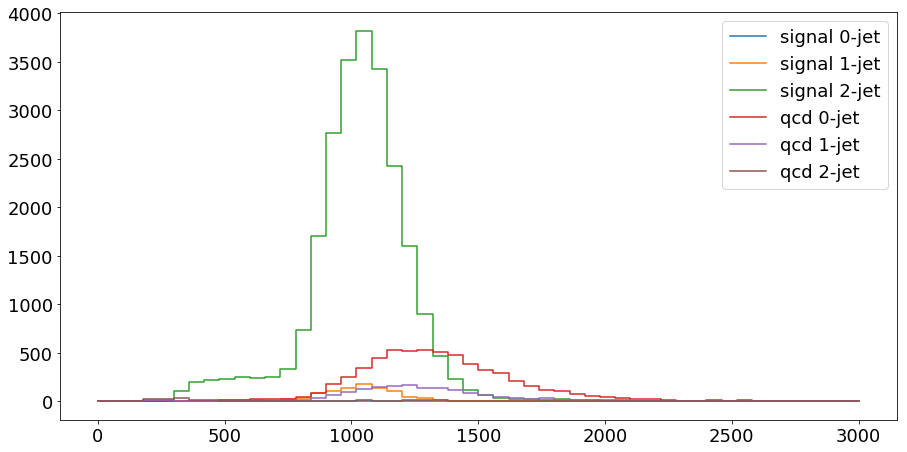

In [89]:
import matplotlib.pyplot as plt
prev = None
for k in ret:
    if prev is None:
        prev = np.zeros_like(ret[k][-1][0])
    for i,vals in enumerate(ret[k]):
        prev = vals[0]
        plt.step(vals[1], [0] + list(prev), label="{} {}-jet".format(k.split('_')[-1].rstrip('.root'),i))
plt.legend()
plt.show()


In [67]:
np.unique(ret.values()[0][-1], return_counts=1)

(array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
        22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 40,
        41]),
 array([   5,  111,  198,  220,  226,  247,  243,  247,  329,  737, 1703,
        2764, 3516, 3823, 3427, 2423, 1599,  902,  470,  233,  120,   61,
          37,   23,   24,   18,   21,    8,   16,   17,   10,    4,    3,
           1,    2]))

data_table :: plotting distrubution(s) for table(s) ['signal norm error', 'down', 'up', 'strange', 'charm', 'bottom', 'gluon']


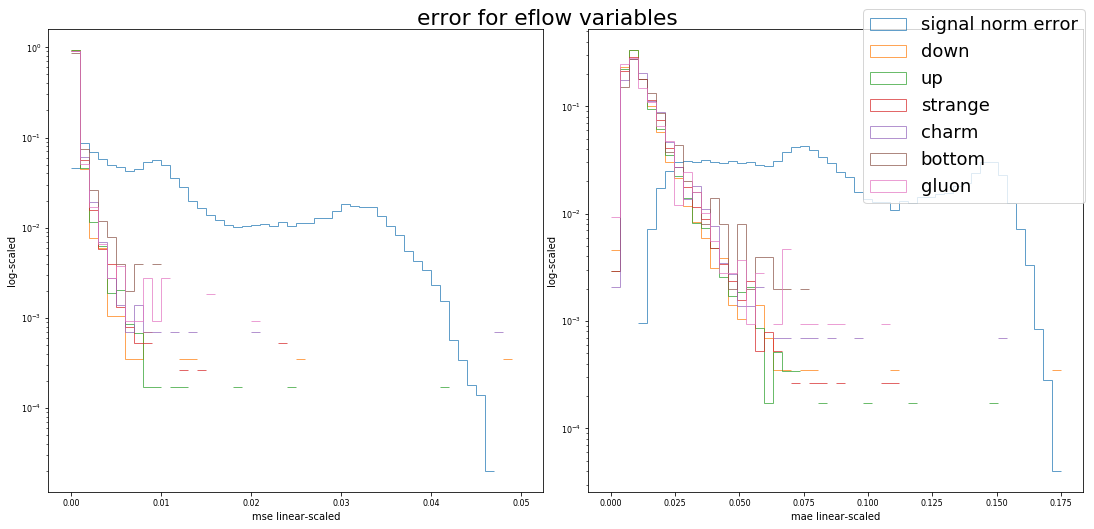

In [93]:
e.error(yscale='log', bins=50, rng=((0., 0.05), (0., 0.175)), split_by_flavor=1)

In [54]:



# def check_cuts(cuts):
#     for k in cuts:
#         s = 0
#         print k +":"
#         for subk in cuts[k]:
#             print " -", str(subk) + ":", cuts[k][subk].shape
#             s += len(cuts[k][subk])
#         print " - size:", s

#     print " - og signal size:", len(e.signal)/2 
#     print " - og test size:", len(e.test)/2

# check_cuts(e.cut_at_threshold(0.025, 'mae'))

AttributeError: File at path /afs/cern.ch/work/l/llepotti/private/CMS/CMSSW_8_0_20/src/autoencodeSVJ/autoencode/module/autoencodeSVJ/hlf_eflow4_16_v0_signal.root already exists!! Choose another.

{'qcd': {0: Int64Index([    4,    31,    34,    38,    40,    49,    61,    62,    70,
                 71,
              ...
              51664, 51666, 51675, 51677, 51683, 51684, 51687, 51690, 51696,
              51700],
             dtype='int64', length=7745),
  1: Int64Index([ 3955, 12653, 15397, 15771, 20374, 25780, 26591, 27473, 32078,
              35581, 36042, 46392],
             dtype='int64'),
  2: Int64Index([], dtype='int64')},
 'signal': {0: Int64Index([    1,     2,     3,     4,     5,     8,     9,    11,    14,
                 15,
              ...
              24733, 24734, 24739, 24740, 24742, 24743, 24745, 24749, 24750,
              24753],
             dtype='int64', length=12364),
  1: Int64Index([    7,    10,    12,    13,    16,    19,    22,    23,    31,
                 34,
              ...
              24738, 24741, 24744, 24746, 24747, 24752, 24754, 24755, 24756,
              24757],
             dtype='int64', length=10147),
  2: Int64Index([  

In [26]:
e.fill_at_threshold()

{'qcd': {0: Int64Index([    4,    31,    34,    38,    40,    49,    61,    62,    70,
                 80,
              ...
              51615, 51619, 51620, 51638, 51643, 51666, 51684, 51687, 51690,
              51696],
             dtype='int64', length=5925),
  1: Int64Index([   71,    75,   116,   158,   210,   212,   233,   262,   273,
                279,
              ...
              51567, 51600, 51629, 51646, 51655, 51664, 51675, 51677, 51683,
              51700],
             dtype='int64', length=1636),
  2: Int64Index([  292,   439,   469,  1163,  1227,  1288,  1599,  1824,  2210,
               2298,
              ...
              48568, 48739, 49343, 49686, 50415, 50974, 51274, 51394, 51424,
              51627],
             dtype='int64', length=196)},
 'signal': {0: Int64Index([4673, 9254, 13101, 14332, 14810, 15471, 18276, 21519], dtype='int64'),
  1: Int64Index([   32,    69,   254,   264,   274,   275,   282,   293,   324,
                330,
              

In [134]:

def check_path(filename):
    head = utils.get_repo_info()['head']
    comps = filter(len, filename.split(os.path.sep))
    for i in range(len(comps)):
        considered = os.path.join(head, os.path.join(*comps[i:])) + ".h5"
        if os.path.exists(considered):
            return considered
    return None
        
filename = '/t3home/llepotti/cmssw_8_0_20/src/autoencodesvj/autoencode/data/training_runs/hlf_eflow3_16_v0'
check_path(filename)

OSError: [Errno 12] Cannot allocate memory

In [120]:
for attr in ['test', 'train', 'qcd', 'signal', 'val', 'val_norm', 'signal_norm']:
    print attr, ':', (ret[attr] == getattr(e, attr)).all().all()
    

test : True
train : True
qcd : True
signal : True
val : True
val_norm : True
signal_norm : True


data_table :: plotting distrubution(s) for table(s) ['qcd test norm error', 'leading signal jet', 'subleading signal jet']


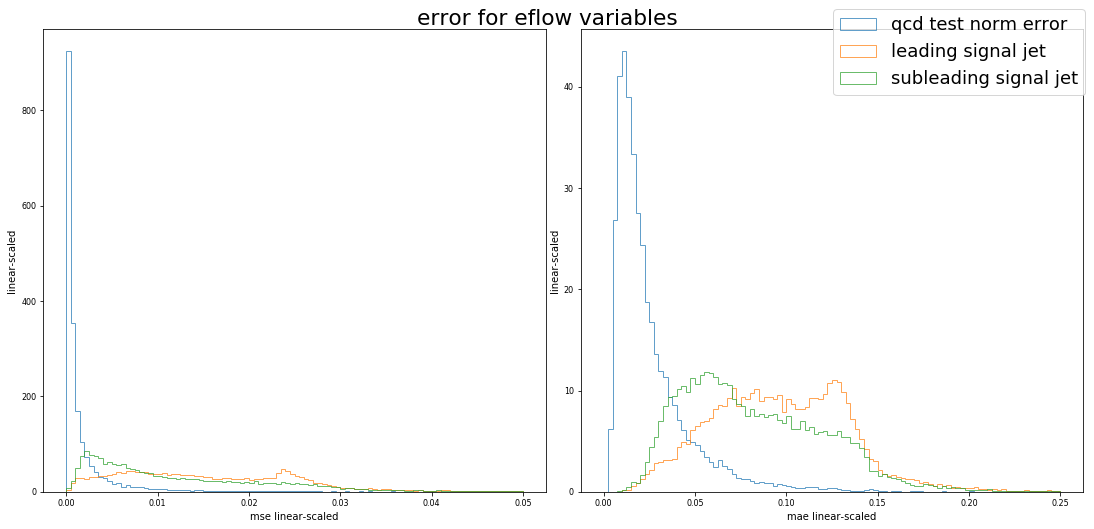

In [59]:
e.error(split_by_leading_jet=1, bins=100, rng=((0,0.05), (0, 0.25)), normed=1, yscale='linear')

In [21]:
import numpy as np 

bins = 21312
rng=(-4,4)
d = np.random.normal(size=1000)
cnts, bin_spc = np.histogram(d, range=rng, bins=bins)
(bin_spc == np.linspace(rng[0], rng[1], bins + 1)).all()

True

In [3]:
e.fill_at_threshold(0.02)

Welcome to JupyROOT 6.12/06
saving root file at /afs/cern.ch/work/l/llepotti/private/CMS/CMSSW_8_0_20/src/autoencodeSVJ/autoencode/module/autoencodeSVJ/hlf_eflow3_16_v0_signal.root
saving root file at /afs/cern.ch/work/l/llepotti/private/CMS/CMSSW_8_0_20/src/autoencodeSVJ/autoencode/module/autoencodeSVJ/hlf_eflow3_16_v0_qcd.root


{u'/afs/cern.ch/work/l/llepotti/private/CMS/CMSSW_8_0_20/src/autoencodeSVJ/autoencode/module/autoencodeSVJ/hlf_eflow3_16_v0_qcd.root': [array([37, 23, 18, ..., 15, 18, 21]),
  array([10, 33, 20, 15, 22, 18,  5,  4,  3, 22, 24, 22, 31, 23,  7,  5,  7,
          8, 21,  4, 17, 19, 27, 24, 26, 23, 23, 18, 13,  5, 24, 17, 21, 22,
         17, 18,  4, 28,  9, 25, 45, 19, 24, 19, 18, 36, 23,  6, 17, 26, 24,
          5, 21, 20, 30]),
  array([ 7,  7,  6, 19, 10])],
 u'/afs/cern.ch/work/l/llepotti/private/CMS/CMSSW_8_0_20/src/autoencodeSVJ/autoencode/module/autoencodeSVJ/hlf_eflow3_16_v0_signal.root': [array([14, 17, 19, 18, 17, 18, 16, 16, 17, 19, 21, 10, 22, 19, 18, 17, 18,
         19, 16, 17,  6, 19, 17, 16, 18, 17, 18, 15, 15, 17, 18, 17, 20, 17,
         18, 20, 10, 18, 19, 16, 14, 15, 18, 19, 21,  8, 16, 21, 19, 17, 18,
         20, 16, 18, 19, 17, 11, 17, 18, 20, 18, 16, 18, 17, 17, 17, 13, 17,
         18, 14, 22, 18, 14, 19, 17, 33, 18, 20, 17, 18, 16, 14, 20, 17, 15,
         14, 1

In [37]:
cuts = e.cut_at_threshold(.02)

# e.recon(split_by_leading_jet=1, qcd=0, cols=4, normed=1, bins=50)

In [116]:
def fill_from_cuts(self, cuts, rng=(0., 3000.), bins=50, var='MT'):
    import ROOT as rt
    import root_numpy as rtnp
    files = []
    for name,cut in cuts.items():
        f = rt.TFile(name + ".root", "RECREATE")
        histos = []
        for jet_n, idx  in cut.items():
            
            hname = name + "_{}_jet".format(jet_n)
            hist = rt.TH1F(hname, hname, bins, *rng)
            
            data = getattr(self, name + "_event").loc[idx][var]
            rtnp.fill_hist(hist, data)
            
            histos.append(hist)
        f.Write()
        files.append(f)
        
    return files
#     all_data = [[] for i in range(len(cuts.values()[0]))]
    
#     for name,cut in cuts.items():
#         for i,(k,idx) in enumerate(cut.items()):
#             data = getattr(self, name + "_event").loc[idx]
#             all_data[i].append((name, data[to_plot]))
    
#     return all_data
            
hist = fill_from_cuts(e, cuts)

In [113]:
f = hist[0]
f.W

<ROOT.TFile object ("signal.root") at 0x11cce3f0>

In [75]:
for i,d in enumerate(data):
    plot = [utils.data_table(var, name=name) for name,var in d]
    plot[0].plot(plot[1:], figname="{} tagged jets".format(i), figsize=5, figloc='upper right')

TypeError: 'int' object is not iterable

In [14]:
e.signal_event

,MET,METEta,METPhi,MT,Mjj
0,475.081085,0.875784,0.374849,1291.659188,1802.235564
1,463.222778,2.061815,-1.783821,950.587393,1515.287491
2,436.396362,0.126562,1.159129,1115.410433,1622.139027
3,472.754791,1.152981,0.373902,1252.156979,1816.854193
4,612.384521,-0.466784,-1.089815,813.417417,1506.764892
5,506.113739,2.092921,-2.873228,1225.698285,1828.269432
6,557.019775,2.143707,2.393610,1233.778540,1923.643462
7,529.519348,-1.956288,1.715536,1174.290399,1863.081190
8,582.397705,-2.485591,2.454824,1166.909151,1832.037180
9,525.504639,1.974988,2.231837,1080.815447,1689.310395


In [ ]:
# e.error(split_by_leading_jet=True, bins=80, rng=((0., 0.012), (0, 0.1)), yscale='linear', normed=1)

In [7]:
import pandas as pd
import numpy as np

self = e
def grab_jet_tags(
    self,
    error_threshold,
    error_metric="mae",
):
    stag = [err[error_metric] > error_threshold for err in self.signal_err_jets]
    qtag = [err[error_metric] > error_threshold for err in self.qcd_err_jets]
    

    qcd_tag_idx = get_event_index(qtag)
#     return qcd_tag_idx, qtag
    qcd_tag_data = [q.loc[qcd_tag_idx + i] for i,q in enumerate(qtag)]
    
    qcd_jet_tags = utils.data_table(
        pd.DataFrame(
            np.asarray(qcd_tag_data).T,
            columns=['jet {}'.format(i) for i in range(len(qtag))],
            index=qcd_tag_idx/2,
        ),
        name='qcd jet tags',
    )
    
    signal_tag_idx = get_event_index(stag)
    signal_tag_data = [s.loc[signal_tag_idx + i] for i,s in enumerate(stag)]

    signal_jet_tags = utils.data_table(
        pd.DataFrame(
            np.asarray(signal_tag_data).T,
            columns=['jet {}'.format(i) for i in range(len(stag))],
            index=signal_tag_idx/2,
        ),
        name='signal jet tags',
    )
    
    return tagged_jet_dict(signal_jet_tags), tagged_jet_dict(qcd_jet_tags)
    
def get_event_index(jet_tags):
    """Get all events index ids from a list of N jet tags 
    in which all N jets originated from that event.
    """
    assert len(jet_tags) > 0
    ret = set(jet_tags[0].index)
    to_add = jet_tags[1:]
    
    for i,elt in enumerate(to_add):
        ret = ret.intersection(elt.index - i - 1)
    
    return np.sort(np.asarray(list(ret)))

def tagged_jet_dict(tags):
    """Dictionary tags
    """
    return dict(
        [
            (
                i,
                tags[tags.sum(axis=1) == i].index
            ) for i in range(tags.shape[1] + 1)
        ]
    )

In [8]:
signal_tags, qcd_tags = grab_jet_tags(e, 0.02)

In [ ]:
sdict = tagged_jets(signal_tags)
qdict = tagged_jets(qcd_tags)

In [ ]:
sdict, qdict

In [ ]:
[i.index for i in self.qcd_jets]

In [ ]:
# even = self.qcd_err.index[self.qcd_err.index % 2 == 1]
# # self.test.loc[even].isin(self.qcd_jets[0].df).any().any()

# qcd_err_jets = [utils.data_table(self.qcd_err.loc[self.qcd_err.index % 2 == i], name=self.qcd_err.name + " jet " + str(i)) for i in range(2)]
# qcd_err_jets[0].plot(qcd_err_jets[1:] + , bins=100, rng=((0, 0.0018), (0, 0.035)), yscale='linear')
# # len(self.qcd_jets[0].df.merge(self.test.loc[even])), len(self.qcd_jets[0].df),b


# # self.qcd_jets[0]

e.qcd_err_jets[0].plot(e.qcd_err_jets[1:] + e.signal_err_jets, bins=100, normed=0, rng=((0., 0.0135), (0., 0.10)), figloc='upper right')

In [ ]:
e.signal_err_jets

In [ ]:
set(qcd_err_jets[0].index).issubset(self.qcd_jets[0].index)

In [ ]:
self.test_norm.head()
self.test.head()

In [ ]:
self.qcd.head()

In [ ]:
self.qcd_jets[0].head()

In [ ]:
import glob
d = utils.data_loader("test", verbose=0)
for f in glob.glob("../../../data/background/base_3/*.h5"):
    d.add_sample(f)

In [ ]:
e.train.loc[11473]

In [ ]:
ret[0]

In [ ]:
j1.head() == self.qcd_jets[0].head()

In [ ]:
utils.get_recon_errors([self.], self.ae)

In [ ]:
def error_from_un_normed()